In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib as mpl
from scipy.optimize import curve_fit

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,12)))
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

# runstr='Dry'
# dftab=pd.read_pickle('dfs/df_run_02_dry_delta_tab.pkl')
# df=pd.read_pickle('dfs/df_run_02_dry.pkl')

runstr='Wet'
dftab=pd.read_pickle('dfs/df_run_02_land_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run_02_land.pkl')

f=2*np.sin(30*(np.pi/180))*7.2921150E-5 #coriolis number
fs=8 #font size
dftab['tal']=round((dftab.t-dftab.tlf)*24,2)
dftab['r']=round(dftab['r'],3)
dftab['rV10max']=round(dftab['rV10max'],3)
r0=dftab.r.unique()[0]

df['tal']=round((df.t-df.tlf)*24,2)

In [60]:
def plot_ts(ax,d):
    ax.plot(tlfs,d.dat,'kx-')
    ax.grid(True)
    ax.set_ylabel(d.lab)
    ax.set_xlabel('t$_{LF}$ (d)')
    
class Var:
    def __init__(self,vid,vdat,vlab):
        self.id=vid
        self.dat=vdat
        self.lab=vlab

class Pltdat:
    def __init__(self,x,y,eq):
        self.x=x
        self.y=y
        self.eq=eq
        
# def get_a_Pdmax(x,y,ax=False):  
#     xcol = np.array(x)[:,np.newaxis]
#     m, _, _, _ = np.linalg.lstsq(xcol, y,rcond=None)
#     if ax:
#         ax.plot(x,y,'r.')
#         ax.set_title('t$_{lf}$='+str(tlf))
#         ax.grid(True)
#         ax.set_xlabel('$\hat{P}^' +str(k)+'$')
#         ax.set_ylabel('$vr_{colRmax} (m/s)$')
#         r2=np.corrcoef(x,y)[0,1]**2
#         ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
#         ax.set_xlim((0,ax.get_xlim()[1]))
#         ax.set_ylim((0,ax.get_ylim()[1]))
#         xl=np.array(ax.get_xlim())
# #         ax.plot(xl,m*xl+c,'k',lw=2)
#         ax.plot(xl,m*xl,'k',lw=2)
#         ax.plot(x,y,'r.')  
#     return(m[0])

# fit y=ax^k, model with VrCol as variable requires k but not a. k controls functional form of decay. k=1 gives exponential, k=2 gives algebraic. 
def get_k_VrPhat(x,y,ax=False):  
    xcol = np.array(x)[:,np.newaxis]
    def polyk(x,a,k):
        return(a*x**k)
    p0=[10, 1]
    fitk,fitcovk=curve_fit(polyk,x,y,p0=p0)
    yfit=polyk(x,fitk[0],fitk[1])
    k=fitk[1]
#     m, _, _, _ = np.linalg.lstsq(xcol, y,rcond=None)
    if ax:
        ax.plot(x,y,'r.')
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.grid(True)
        ax.set_xlabel('$\hat{P}$')
        ax.set_ylabel('$vr_{colRmax} (m/s)$')
        r2=np.corrcoef(y,yfit)[0,1]**2
        ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
        ax.text(0.05,0.75,"k={:2.2f}".format(k),transform=ax.transAxes,fontsize=fs)
        ax.set_xlim((0,ax.get_xlim()[1]))
        ax.set_ylim((0,ax.get_ylim()[1]))
        xl=np.array(ax.get_xlim())
        ax.plot(x,yfit,'k',lw=2)
        ax.plot(x,y,'r.')  
    return(k)

def fit_thalf_exp(t,y,ylab,ax=False):
    ly = np.log(y)
    K, A_log = np.polyfit(t, ly, 1)
    A = np.exp(A_log)
    thalf=-np.log(2)/K
    yf=np.exp(A_log+t*K)
    
    if ax:
        ax.plot(t*24,y,'k')
        ax.plot(t*24,yf,'--r')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel(ylab)
        ax.set_xlim((0,12))        
    return(thalf)

# def fit_thalf_alg(t,y,ylab,ax=False):
#     def algd(x,k,a):
#         return(1/(k*x+a))
# #     print(t)
# #     t=t-t.values[0]
#     pa0=[0.07602148, 0.01205749]
#     fita,fitcova=curve_fit(algd,t,y,p0=pa0)
#     thalf=fita[1]/fita[0]
#     yf=algd(t,fita[0],fita[1])
# #     print(fita) 
#     if ax:
#         ax.plot(t*24,y,'k')
#         ax.plot(t*24,yf,'--r')
#         ax.grid(True)
#         ax.set_title('t$_{lf}$='+str(tlf))
#         ax.set_xlabel('t (h)')
#         ax.set_ylabel(ylab)
#         ax.set_xlim((0,12))
#         ax.set_ylim((0,0.1))
#     return(thalf)

Getting vars
Calculating half lives
k opt= 1.00001
k mean= 1.217396440614956
plotting time series


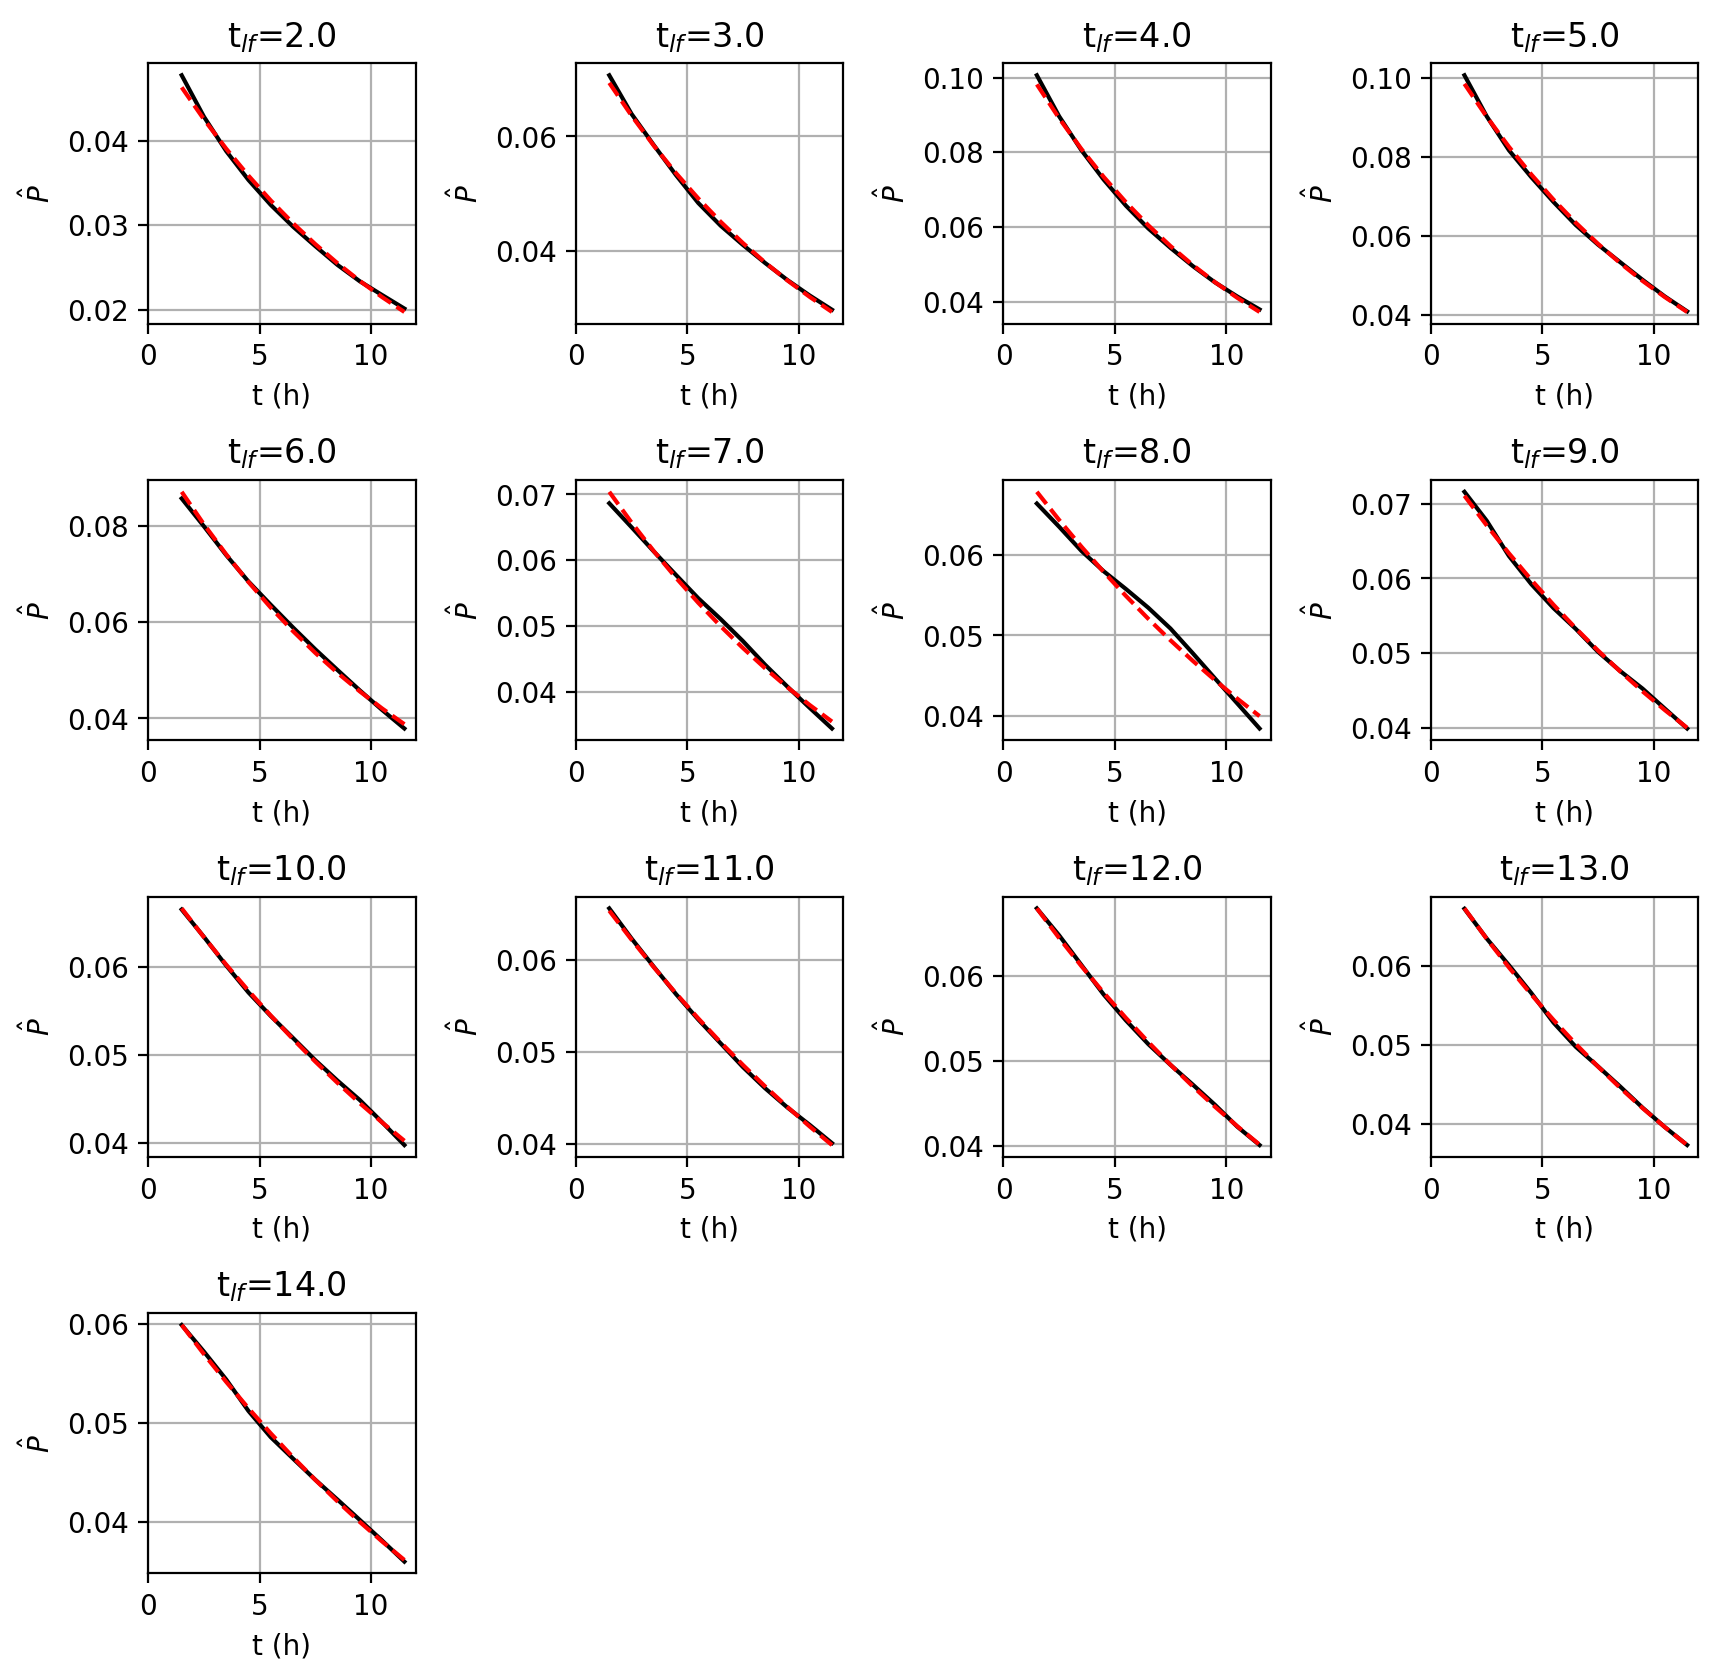

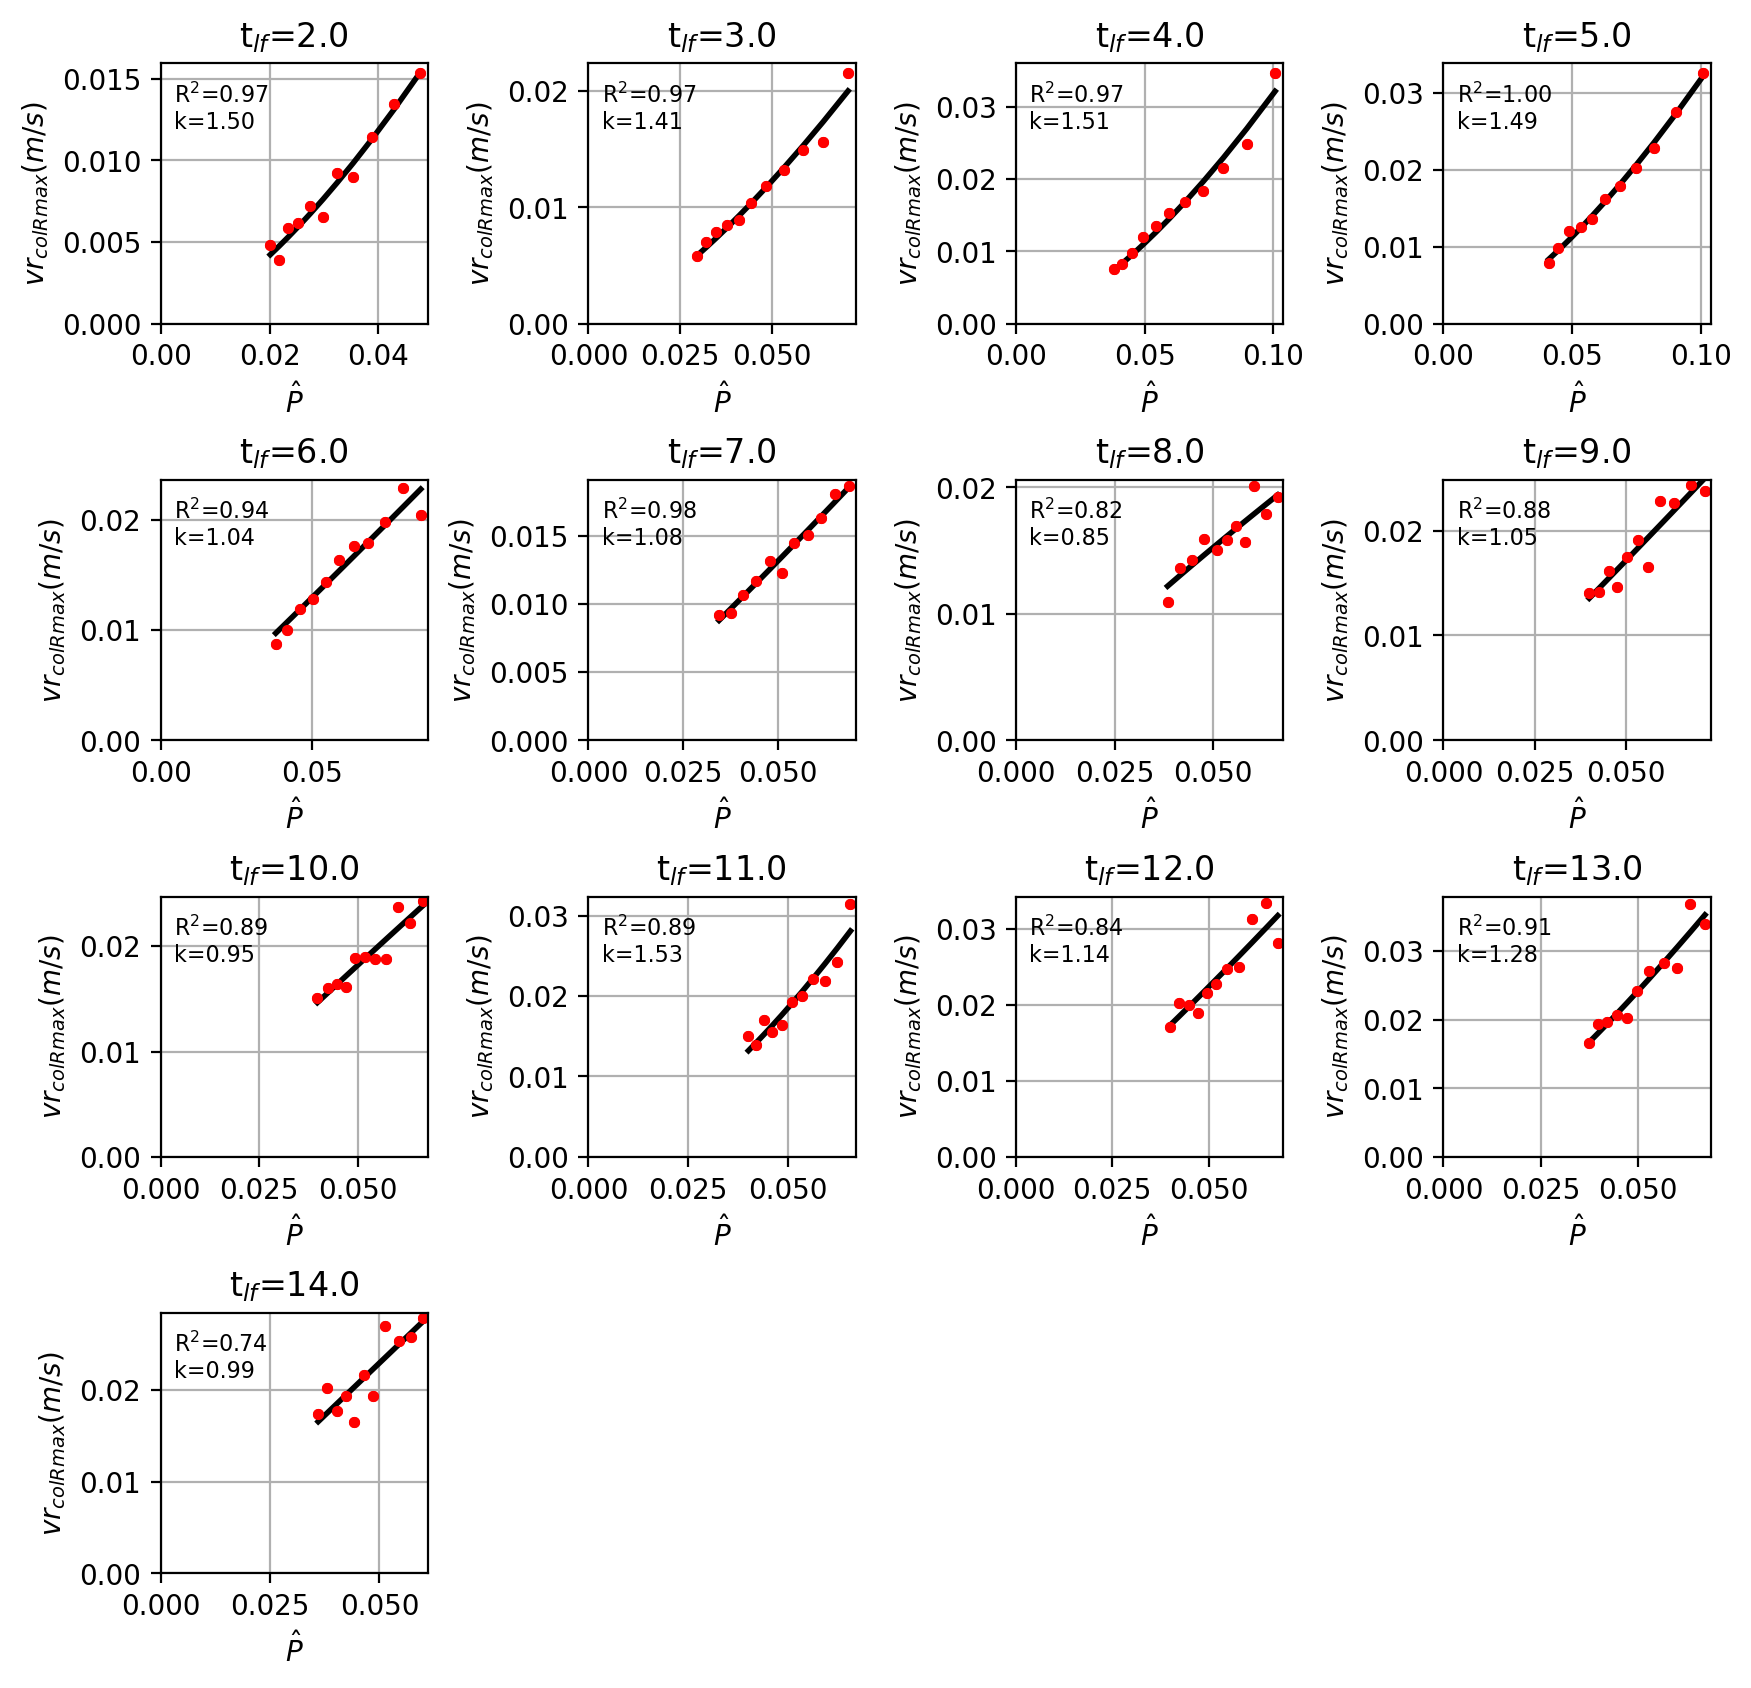

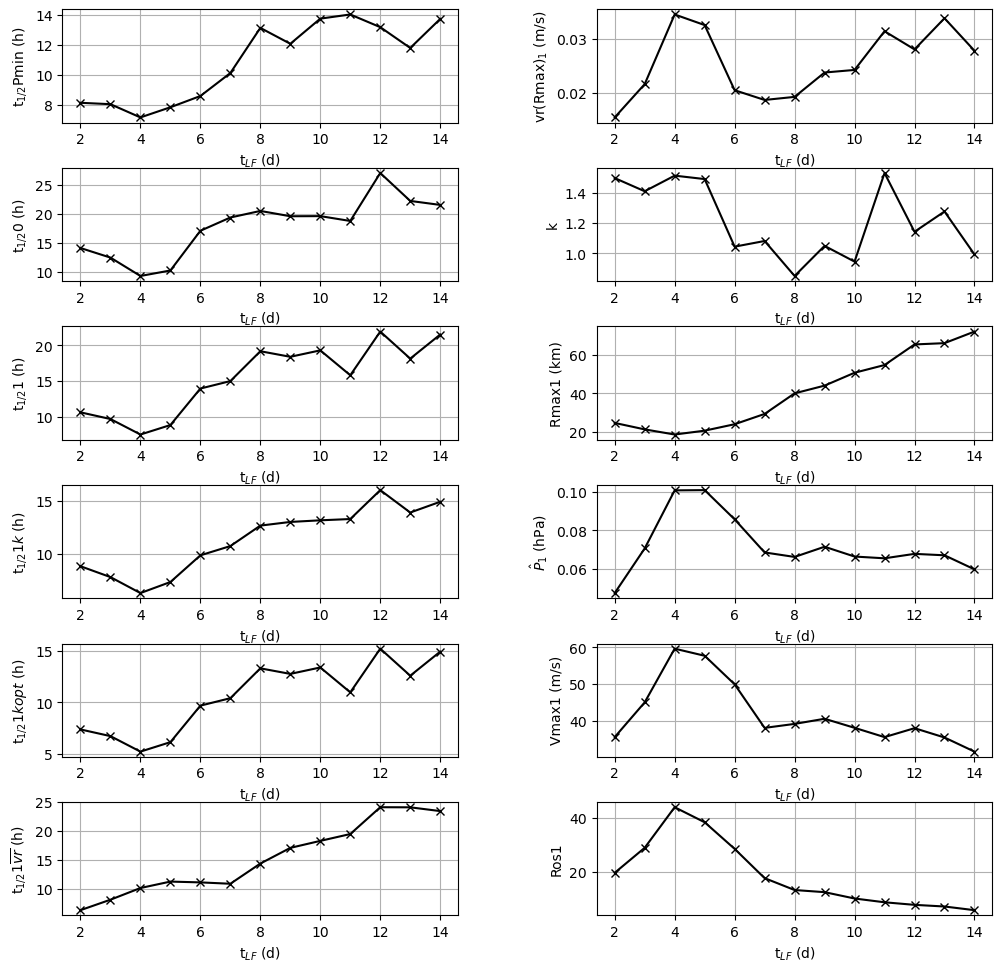

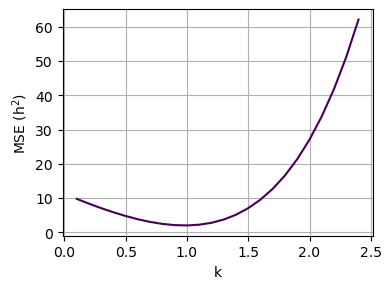

In [61]:
figs=[]; axss=[]
for i in range(2):
    fig,axs=plt.subplots(4,4,sharex=False,dpi=200,figsize=(10,10))
    plt.subplots_adjust(hspace=0.6,wspace=0.6)
    for i in range(13,len(axs.flat)):
        axs.flat[i].axis('off')
    figs.append(fig)
    axss.append(axs)
    
fig5,axs5=plt.subplots(6,2,sharex=False,dpi=100,figsize=(12,12))
plt.subplots_adjust(hspace=0.4,wspace=0.35)
# for i in range(11,len(axs5.flatten(order='F'))):
#     axs5.flatten(order='F')[i].axis('off')

figk,axk=plt.subplots(1,1,sharex=False,dpi=100,figsize=(4,3))

thP=[];k_VrPhat=[];vrRmax1=[]
Rmax0=[];Pmin0=[];Vmax0=[];Ros0=[]
Rmax1=[];Pmin1=[];Vmax1=[];Ros1=[]

Pe=1016
tmind=1
tmaxd=12
tmina=1
tmaxa=12
# k=2


tlfs=dftab.tlf.unique()
# tlfs=np.delete(tlfs,11)

print('Getting vars')
for n,tlf in enumerate(tlfs):
    
    df0=df.query('tlf==@tlf & tal==0').iloc[0]
    Pmin0.append(df0.Pmin)
    Rmax0.append(df0.rV10max)
    Vmax0.append(df0.V10max)
    Ros0.append(Vmax0[-1]/(1000*Rmax0[-1]*f))

    # get 'initial' params
    df1=dftab.query('tlf==@tlf & tal==1.5')
    df1=df1.iloc[np.argmin((df1.r-df1.rV10max).abs())]
    rmax_tlf=df1.r

    Pmin1.append(df1.Pmin)
    Rmax1.append(df1.rV10max)
    Vmax1.append(df1.V10max)
    Ros1.append(Vmax1[-1]/(1000*Rmax1[-1]*f))
        
    # get vr
    df1=dftab.query('tlf==@tlf & tal==1.5')
    df1=df1.iloc[np.argmin((df1.r-df1.rV10max).abs())]
    vrRmax1.append(df1.vrcol)
        
    # fit decay
    dfdt=dftab.query('tlf==@tlf & r == @r0 & tal>=@tmind & tal <= @tmaxd')     
    thP.append(24*fit_thalf_exp(dfdt.tal/24,(Pe-dfdt.Pmin)/Pe,ax=axss[0].flat[n],ylab='$\hat{P}$'))
    
    # fit k
    dfat=dftab.query('tlf == @tlf & r == @rmax_tlf & tal >= @tmina & tal <= @tmaxa') 
    x=((Pe-dfat.Pmin)/Pe)
    y=dfat.vrcol
    k_VrPhat.append(get_k_VrPhat(x,y,ax=axss[1].flat[n]))

Pmin0=np.array(Pmin0)
Vmax0=np.array(Vmax0)
Rmax0=np.array(Rmax0)
Ros0=np.array(Ros0)
Pmin1=np.array(Pmin1)
Vmax1=np.array(Vmax1)
Rmax1=np.array(Rmax1)
Ros1=np.array(Ros1)

Phat0=(Pe-Pmin0)/Pe
Phat1=(Pe-Pmin1)/Pe


# a=a_vrPhat2
# print('CoV(a)='+str(np.std(a)/np.mean(a)))

print('Calculating half lives')

def calc_thalf(Rmax0,Phat0,vrRmax0,k=2):
    return(1000*Rmax0*Phat0/(2*vrRmax0)*((2**(k-1)-1)/(k-1)))

tha0=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a)/(60*60) for Rmax0a,Pmin0a,vrRmax0a in zip (Rmax0,Pmin0,vrRmax1)]
tha1=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a)/(60*60) for Rmax0a,Pmin0a,vrRmax0a in zip (Rmax1,Pmin1,vrRmax1)]
tha1k=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a,k=ka)/(60*60) for Rmax0a,Pmin0a,vrRmax0a,ka in zip (Rmax1,Pmin1,vrRmax1,k_VrPhat)]

tha1m=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,np.mean(vrRmax1))/(60*60) for Rmax0a,Pmin0a in zip (Rmax1,Pmin1)]


# optimize k
def erf(a,b):
    return(np.mean((np.array(a)-np.array(b))**2))

def msek(k):
    tha1k=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a,k=k)/(60*60) for Rmax0a,Pmin0a,vrRmax0a in zip (Rmax1,Pmin1,vrRmax1)]
    return(erf(tha1k,thP))
ks=np.arange(0.1,2.5,.1)+0.00001
e=np.zeros(ks.shape)
for n,k in enumerate(ks):
    e[n]=msek(k)
axk.plot(ks,e)
axk.grid(True)
axk.set_xlabel('k')
axk.set_ylabel('MSE (h$^2$)')

kopt=ks[np.argmin(e)]
tha1ko=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a,k=kopt)/(60*60) for Rmax0a,Pmin0a,vrRmax0a in zip (Rmax1,Pmin1,vrRmax1)]
print('k opt=',kopt)
print('k mean=',np.mean(k_VrPhat))

vars=[
    Var('thP',thP,'t$_{1/2}$Pmin (h)'),
    Var('tha0',tha0,'t$_{1/2}0$ (h)'),
    Var('tha1',tha1,'t$_{1/2}1$ (h)'),
    Var('tha1k',tha1k,'t$_{1/2}1k$ (h)'),
    Var('tha1ko',tha1ko,'t$_{1/2}1k opt$ (h)'),
    Var('tha1m',tha1m,'t$_{1/2}1 \overline{vr}$ (h)'),
    
    Var('vrRmax1',vrRmax1,'vr(Rmax)$_1$ (m/s)'),
    Var('k',k_VrPhat,'k'),

    Var('Rmax1',Rmax1,'Rmax1 (km)'),
    Var('Phat1',Phat1,'$\hat{P}_1$ (hPa)'),
    Var('Vmax1',Vmax1,'Vmax1 (m/s)'),
    Var('Ros1',Ros1,'Ros1'),
    
    Var('Rmax0',Rmax0,'Rmax0 (km)'),
    Var('Phat0',Phat0,'$\hat{P}_0$ (hPa)'),
    Var('Vmax0',Vmax0,'Vmax0 (m/s)'),
    Var('Ros0',Ros0,'Ros0'),
    
#     Var('tha_aRmaxPhat',tha_aRmaxPhat,'t$_{1/2}$aRmaxPhat (h)'),
#     Var('a_vrPhat2',a_vrPhat2,'a vr/$\hat{P}^2$ (m/s)'),
   
#     Var('V2overP',Vmax0**2/(Pe-Pmin0),'Vmax0$^2$/Pmin0 (m2/s2 / hPa)'),
#     Var('Ros0rec',1/Ros0,'1/Ros0'),
#     Var('Vmax0rec',1/Vmax0,'1/Vmax0 (s/m)'),
#     Var('Vmax0rec2',1/Vmax0**2,'1/Vmax0$^2$ (s$^2$/m$^2$)'),
#     Var('sqrtVmax0',np.sqrt(Vmax0-25),'sqrt(Vmax0-25) (m/s)'),
]

# if runstr=='Wet':
#     vars=vars+(Var('thR',thR,'t$_{1/2}$Rain (h)'),)

vd = {var.id: var for var in vars}

print('plotting time series')
axsf=axs5.flatten(order='F')
for ax,d in zip(axsf,vars):
    plot_ts(ax,d)

plotting scatters


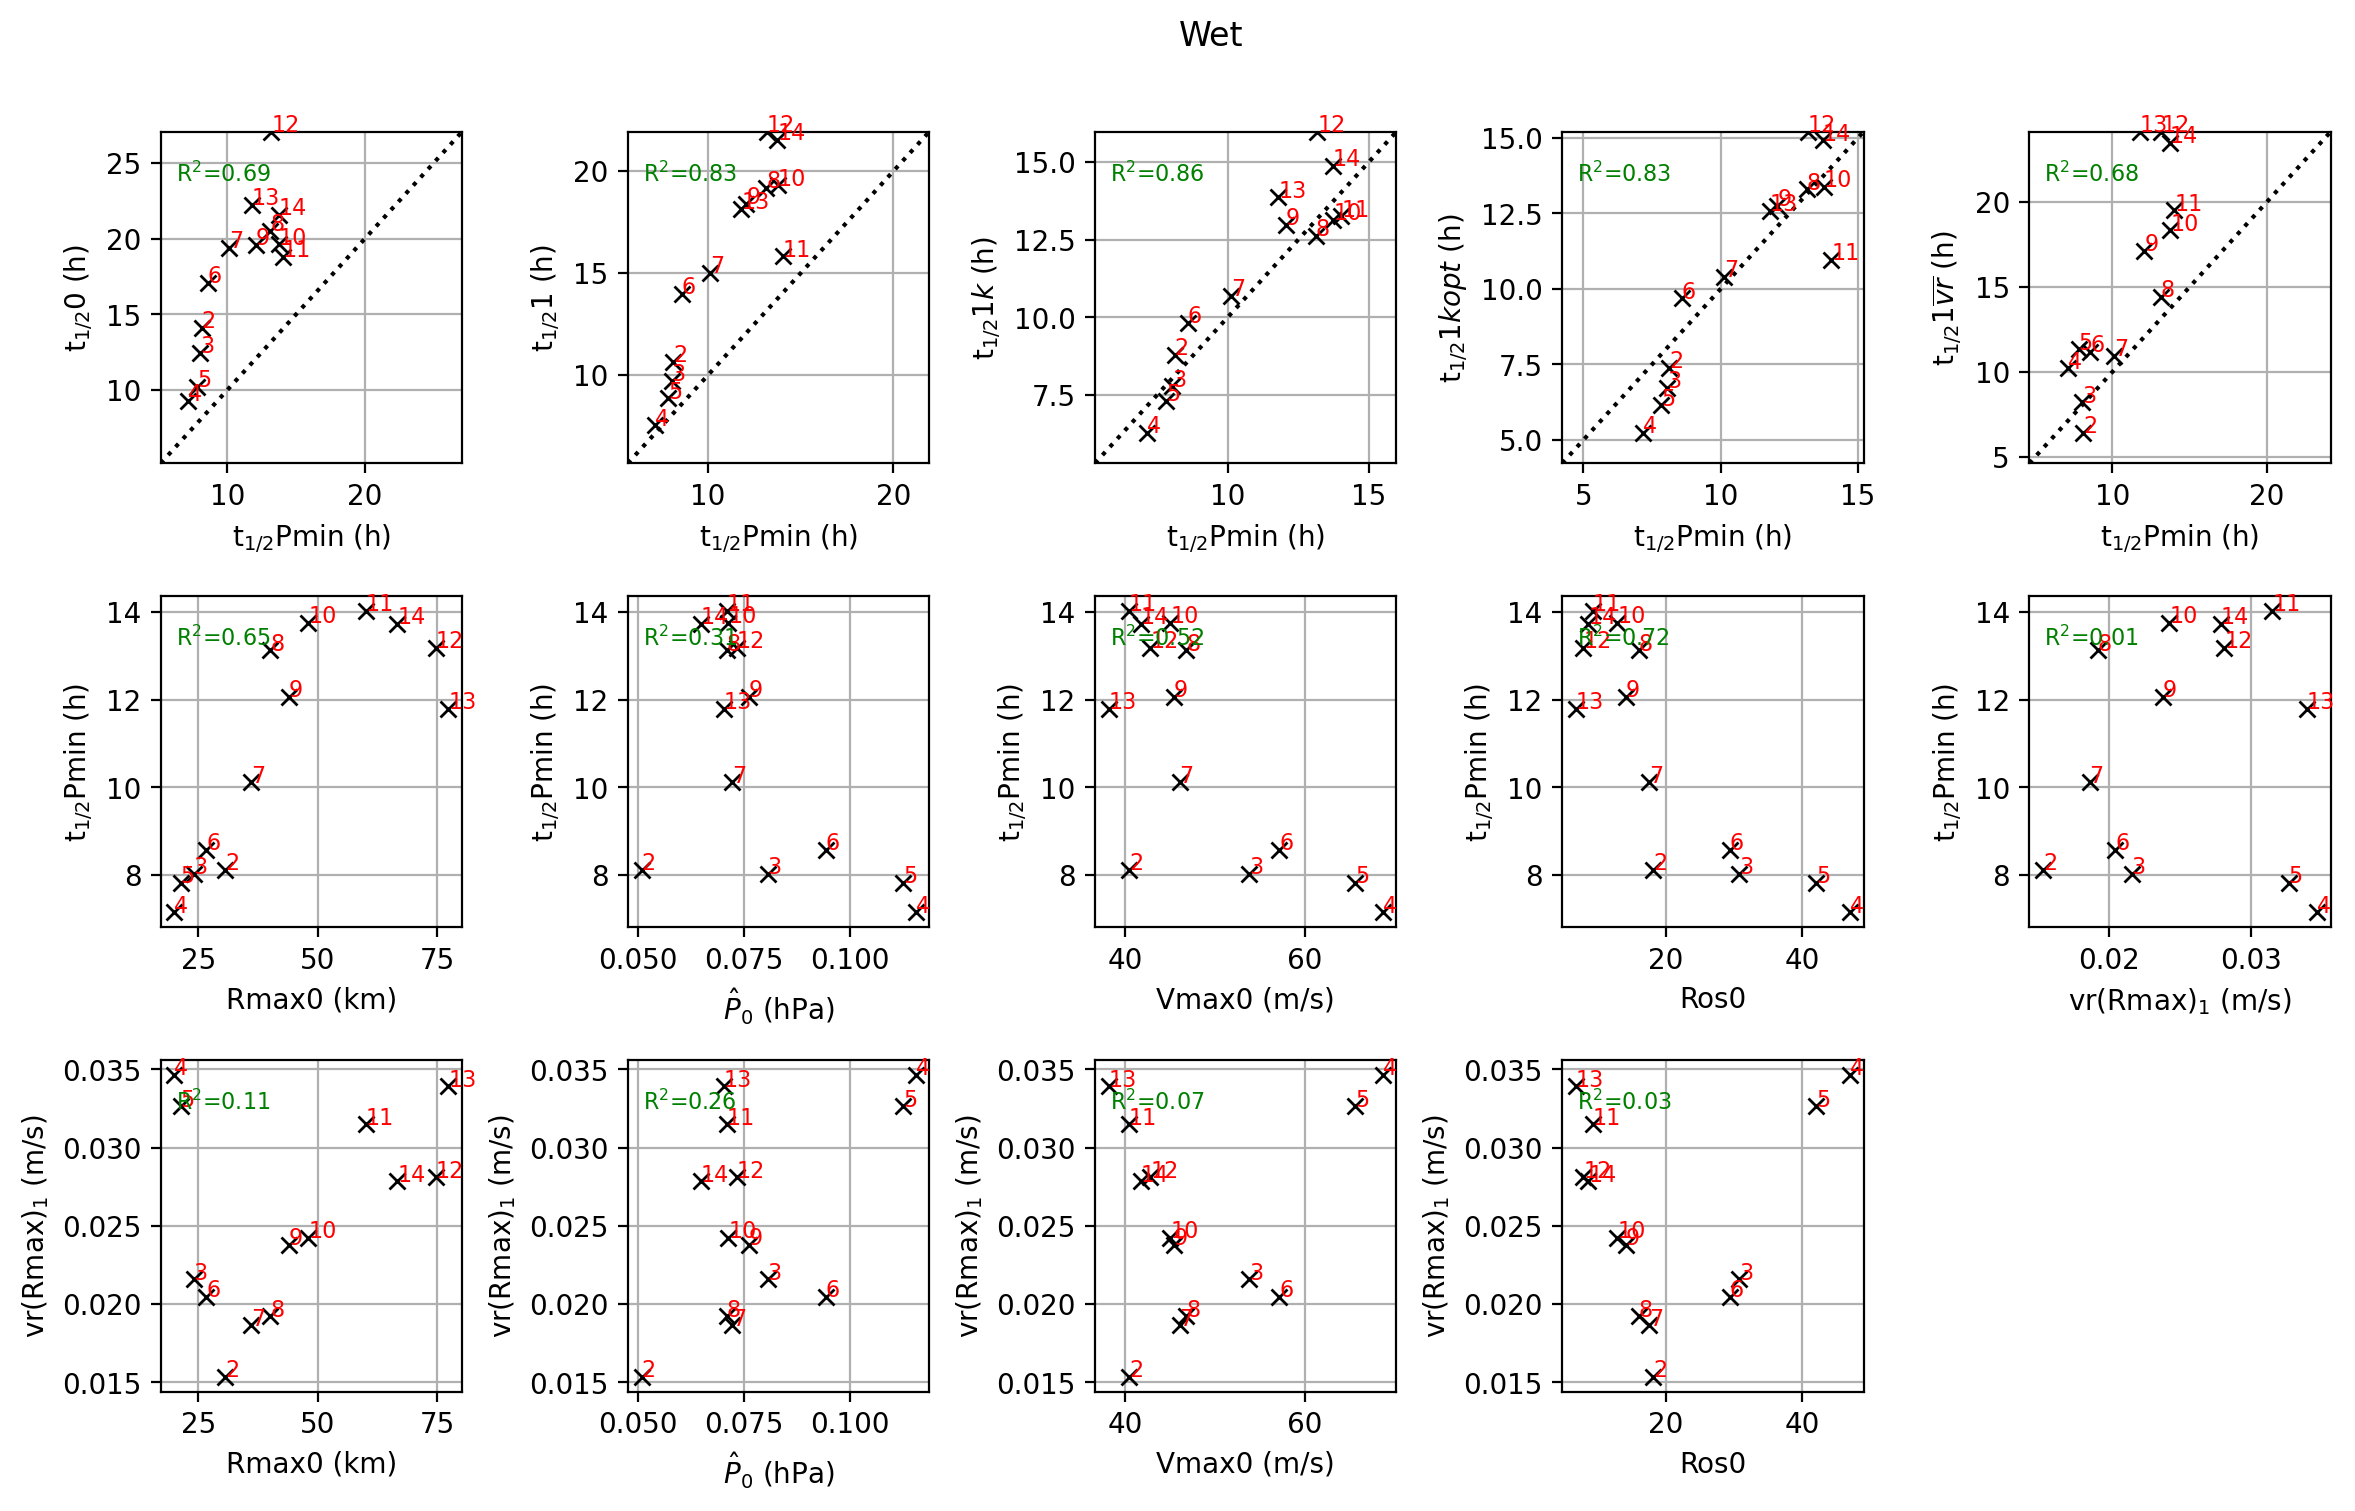

In [62]:
def plot_scat(ax,d):
    ax.plot(d.x.dat,d.y.dat,'xk')
    ax.grid(True)
    ax.set_xlabel(d.x.lab)
    ax.set_ylabel(d.y.lab)
    for tlf,x,y in zip(tlfs,d.x.dat,d.y.dat):
        ax.text(x,y,round(tlf),fontsize=fs,color='r')
    r2=np.corrcoef(d.x.dat,d.y.dat)[0,1]**2
    ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs,color='g')
    if d.eq:
        axr=[np.min((d.x.dat,d.y.dat)),np.max((d.x.dat,d.y.dat))]
        axr[0]=axr[0]-0.1*(axr[1]-axr[0])
        axr[1]=axr[1]+0.1*(axr[1]-axr[~0])
        ax.plot(axr,axr,':k')
        ax.set_xlim(axr)
        ax.set_ylim(axr)
        
print('plotting scatters')
fs=8
fig,axs=plt.subplots(3,5,dpi=200,figsize=(14,7))
plt.subplots_adjust(hspace=0.4,wspace=0.55,top=.9,bottom=0)
# for i in range(2,3):
#     axs.flatten()[i].axis('off')
        
pltdats=(
    Pltdat(vd['thP'],vd['tha0'],True),
    Pltdat(vd['thP'],vd['tha1'],True),
    Pltdat(vd['thP'],vd['tha1k'],True),
    Pltdat(vd['thP'],vd['tha1ko'],True),
    Pltdat(vd['thP'],vd['tha1m'],True), 
    
#     Pltdat(vd['Rmax0'],vd['Rmax1'],True),
#     Pltdat(vd['Phat0'],vd['Phat1'],True),
    
    Pltdat(vd['Rmax0'],vd['thP'],False),
    Pltdat(vd['Phat0'],vd['thP'],False),
    Pltdat(vd['Vmax0'],vd['thP'],False),
    Pltdat(vd['Ros0'],vd['thP'],False),
    Pltdat(vd['vrRmax1'],vd['thP'],False),

    Pltdat(vd['Rmax0'],vd['vrRmax1'],False),
    Pltdat(vd['Phat0'],vd['vrRmax1'],False),
    Pltdat(vd['Vmax0'],vd['vrRmax1'],False),
    Pltdat(vd['Ros0'],vd['vrRmax1'],False),  
#     Pltdat(vd['sqrtVmax0'],vd['vrRmax0'],False),
)

# axs=np.delete(axs.flatten(),[2])
for ax,pltdat in zip(axs.flatten(),pltdats):
    plot_scat(ax,pltdat)
plt.suptitle(runstr);
for i in range(len(pltdats),len(axs.flat)):
    axs.flat[i].axis('off')

plotting scatters


Text(0.5, 0, '$\\hat{P}$')

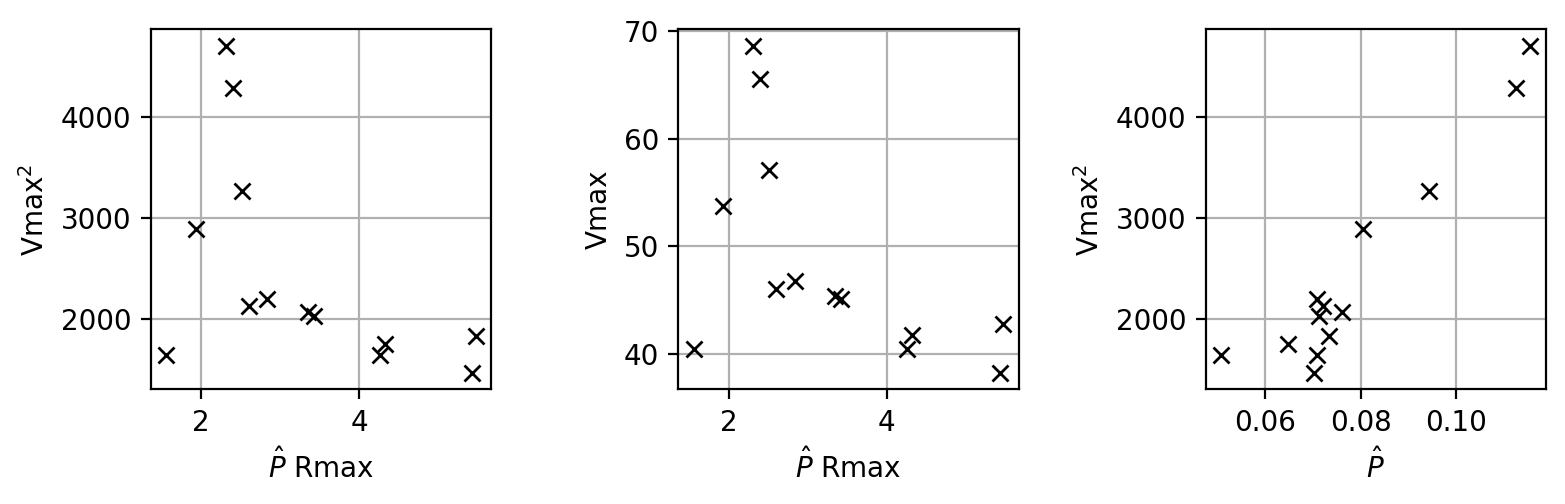

In [63]:
print('plotting scatters')
fs=8
fig,axs=plt.subplots(1,3,dpi=200,figsize=(9,2))
plt.subplots_adjust(hspace=0.4,wspace=0.55,top=.9,bottom=0)
# for i in range(2,3):
#     axs.flatten()[i].axis('off')

ax=axs.flat[0]
ax.plot(Phat0*Rmax0,Vmax0**2,'kx')
ax.grid(True)
ax.set_ylabel('Vmax$^2$')
ax.set_xlabel('$\hat{P}$ Rmax')

ax=axs.flat[1]
ax.plot(Phat0*Rmax0,Vmax0**1,'kx')
ax.grid(True)
ax.set_ylabel('Vmax')
ax.set_xlabel('$\hat{P}$ Rmax')

ax=axs.flat[2]
ax.plot(Phat0,Vmax0**2,'kx')
ax.grid(True)
ax.set_ylabel('Vmax$^2$')
ax.set_xlabel('$\hat{P}$')


0.0012071148608743293
0.009071568742843886
[ 6874.9961434   9026.85958378 10253.97765182 10720.41588986
 10241.89812824  9736.75774586 12842.40195023 11452.84221193
 12942.87594692 11855.28388073 11790.03680538  9412.3116695
 11982.27892071]


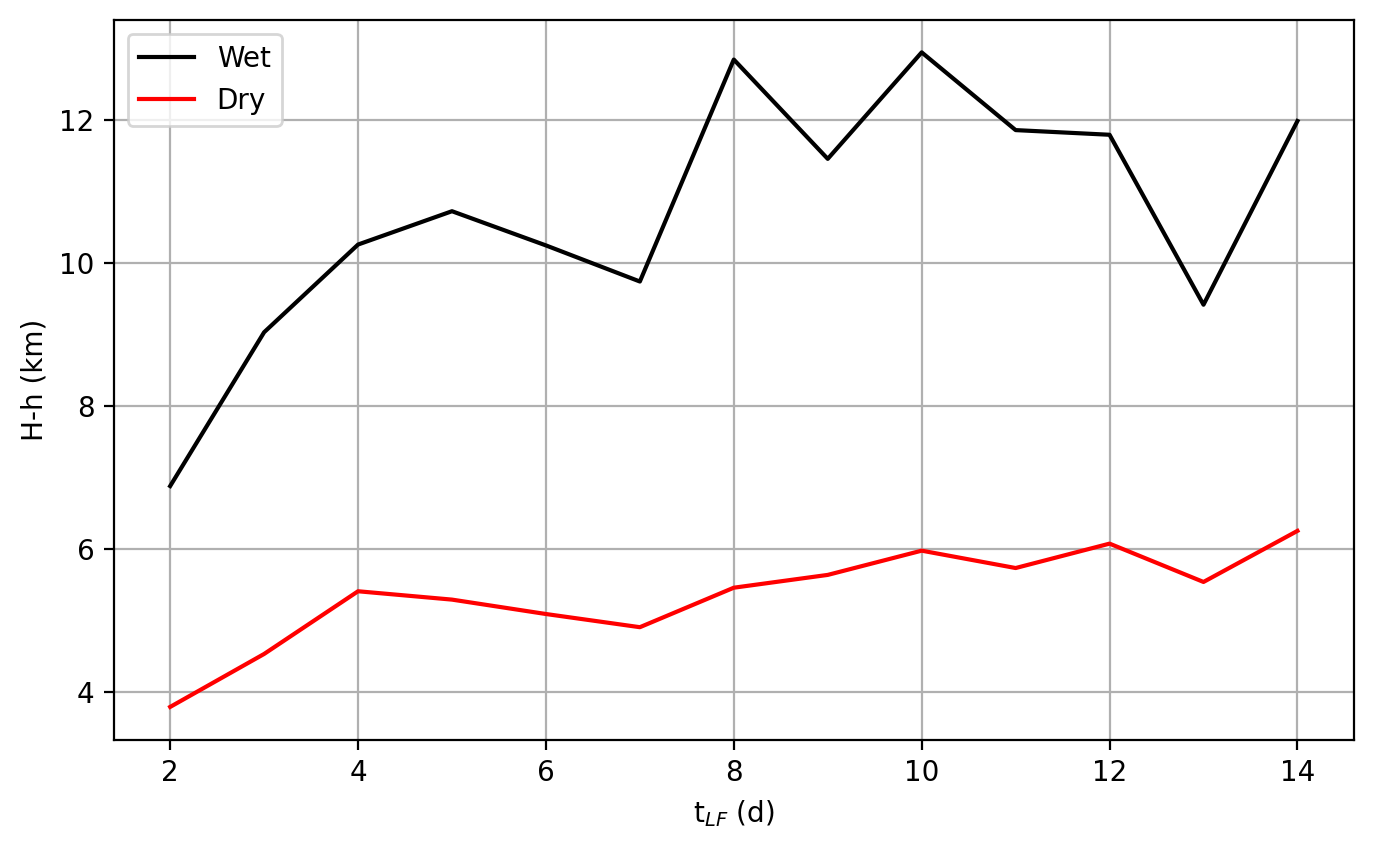

In [68]:
def calc_CD(z,z0,k):
    CD=k**2/(np.log(z/z0))**2
    return(CD)

def calc_dH(X,CD,thalf,Vt0):
    dH=thalf*X**2*CD*Vt0
    return(dH)

z0ocean=0.0001
z0land=0.15
CDocean=calc_CD(10,z0ocean,0.4)
CDland=calc_CD(10,z0land,0.4)
print(CDocean)
print(CDland)


dH=calc_dH(0.8,CDland,np.array(thP)*60*60,Vmax0)

print(dH)
fig,ax=plt.subplots(1,1,dpi=200,figsize=(8,4))
plt.subplots_adjust(hspace=0.4,wspace=0.55,top=.9,bottom=0)
ax.plot(tlfs,dH/1000,'k')
ax.plot(tlfs,dHd/1000,'r')
ax.grid(True)
ax.set_ylabel('H-h (km)')
ax.set_xlabel('t$_{LF}$ (d)')
plt.legend(('Wet','Dry'))
# ax.set_title(runstr)